In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import tqdm

In [2]:
def detect_horizontal_lines(image_path, scale=0.5):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image to make it manageable and to smooth out high DPI noise
    img = cv2.resize(img, None, fx=scale, fy=scale)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)

    # Detect edges
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, rho=1, theta=np.pi / 180, threshold=100,
        minLineLength=300, maxLineGap=10
    )

    # Filter horizontal lines
    line_y_coords = []
    vis = img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if abs(angle) < 5:  # Nearly horizontal
            cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 1)
            line_y_coords.append((y1 + y2) // 2)

    # Sort and deduplicate nearby lines
    line_y_coords = sorted(set(line_y_coords))
    deduped_lines = []
    threshold = 10
    for y in line_y_coords:
        if not deduped_lines or y - deduped_lines[-1] > threshold:
            deduped_lines.append(y)

    # Show result
    #plt.figure(figsize=(10, 14))
    #plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    #plt.title("Detected Horizontal Lines")
    #plt.axis("off")
    #plt.show()

    return deduped_lines, img

In [3]:
def crop_and_save_lines(image, lines, base_name, output_folder, pad=5):
    os.makedirs(output_folder, exist_ok=True)
    cropped_lines = []
    for i in range(len(lines) - 1):
        y1 = max(0, lines[i] - pad)
        y2 = min(image.shape[0], lines[i+1] + pad)
        crop = image[y1:y2]
        cropped_lines.append(crop)

    print("Cropped Finished")

    if cropped_lines == None:
        print("Cropped Failed ")
    

    return cropped_lines
        


In [4]:
def process_image(image_path, output_folder):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    image_path
    if image_path is None:
        print(f"Error reading {image_path}")
        return

    lines, scled = detect_horizontal_lines(image_path)
    if lines == "None":
        print("lines are empty")
    cropped_lines = crop_and_save_lines(scled, lines, base_name, output_folder)

    for i,c in enumerate(cropped_lines):
        outpath = os.path.join(output_folder, f"{base_name}_line_{i+1:02}.png")
        cv2.imwrite(outpath, cv2.cvtColor(c, cv2.COLOR_BGR2RGB))

In [5]:
def preprocess_folder(input_folder, output_folder):
    image_files = [f for f in os.listdir(input_folder)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    for img_file in image_files:
        image_path = os.path.join(input_folder, img_file)
        print(image_path)
        process_image(image_path, output_folder)

In [6]:
import create_label

create_label.create_dataset_json(
    image_dir="cropped",
    label_dir="labels",
    output_file='dataset.json'
)

✅ Saved 88 items to dataset.json


In [7]:
create_label.convert_json_to_csv("dataset.json","dataset.csv")

✅ Converted to dataset.csv with 88 entries.


In [8]:
from torch.utils.data import DataLoader
import collate_fn
import HWLD
dataset = HWLD.HandwritingLineDataset("dataset.csv")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn.ctc_collate_fn)

batch = next(iter(dataloader))
print("Image batch shape:", batch["images"].shape)
print("Input lengths:", batch["input_lengths"])
print("Label lengths:", batch["label_lengths"])
print("Decoded labels:", batch["label_strs"])


Image batch shape: torch.Size([4, 1, 32, 512])
Input lengths: tensor([128, 128, 128, 128])
Label lengths: tensor([47, 40, 52, 51])
Decoded labels: ['sensors sending data Edge computing can prevent', 'latency and increase traffic if multiple', 'Catholic Church Orthodox Christians believe that the', 'case the problem is to plan a feasible path between']


In [9]:
import matplotlib.pyplot as plt

def show_batch(batch, idx2char):
    for i in range(len(batch["images"])):
        img = batch["images"][i][0].numpy()  # Get [H, W]
        label = batch["label_strs"][i]
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
        plt.show()

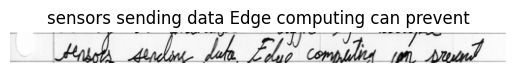

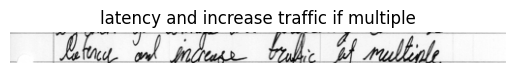

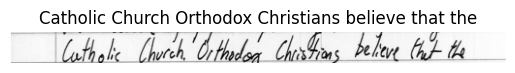

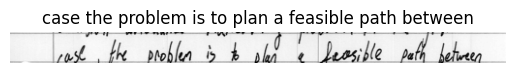

In [10]:
show_batch(batch, dataset.idx2char) 